# Metropolis-Hastings sampling of MLP weights using iris data

Sampling the weights of a multi-layer perceptron (MLP) using the iris data and Metropolis-Hastings algorithm.

In [1]:
## Import packages

import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.distributions import Normal

from eeyore.api import indexify
from eeyore.data import Iris
from eeyore.models import mlp
from eeyore.kernels import NormalKernel
from eeyore.mcmc import MetropolisHastings

from timeit import default_timer as timer
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Avoid issuing memory warning due to number of plots

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
## Load iris data

iris = indexify(Iris)()
dataloader = DataLoader(iris, batch_size=150, shuffle=True)

In [4]:
## Setup MLP model

hparams = mlp.Hyperparameters(dims=[4, 3, 3], activations=[torch.sigmoid, None])
model = mlp.MLP(
    hparams=hparams,
    loss=lambda x, y: nn.CrossEntropyLoss(reduction='sum')(x, torch.argmax(y, 1)),
    dtype=torch.float64
)
model.prior = Normal(
    torch.zeros(model.num_params(), dtype=model.dtype),
    np.sqrt(3)*torch.ones(model.num_params(), dtype=model.dtype)
)

In [5]:
## Setup Metropolis-Hastings sampler

theta0 = model.prior.sample()
num_params = model.num_params()
kernel = NormalKernel(torch.zeros(num_params), np.sqrt(0.025)*torch.ones(num_params), dtype=torch.float64)
sampler = MetropolisHastings(model, theta0, dataloader, kernel)

In [6]:
## Run Metropolis-Hastings sampler

start_time = timer()

sampler.run(num_iterations=11000, num_burnin=1000)

end_time = timer()
print("Time taken: {}".format(timedelta(seconds=end_time-start_time)))

Time taken: 0:00:15.911686


In [7]:
## Compute acceptance rate

sampler.chain.acceptance_rate()

0.0015999999595806003

In [8]:
## Compute Monte Carlo mean

sampler.chain.mean()

tensor([ 2.0104,  2.3383, -3.2003, -3.2394, -0.8396, -3.0336,  4.1028,  2.5450,
         1.8318, -0.8482, -0.4709,  0.6169,  1.3251,  0.8236,  0.5792,  0.4094,
        -3.6330,  1.0623,  0.9144,  4.3900, -3.4866, -5.2425,  2.3554, -0.2726,
         1.7555,  0.3449,  2.4243], dtype=torch.float64)

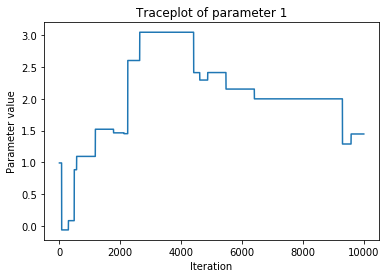

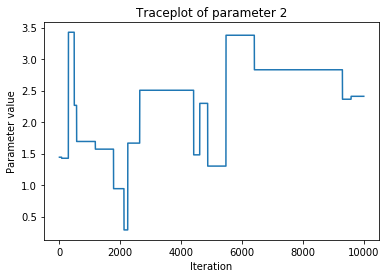

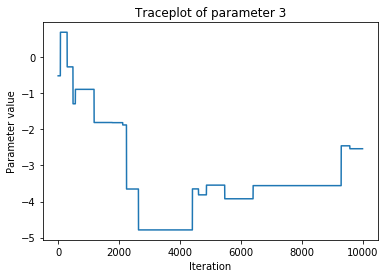

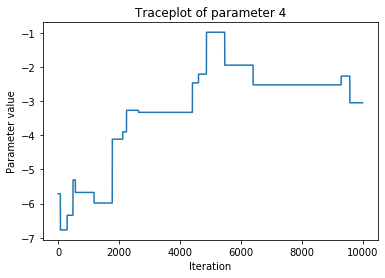

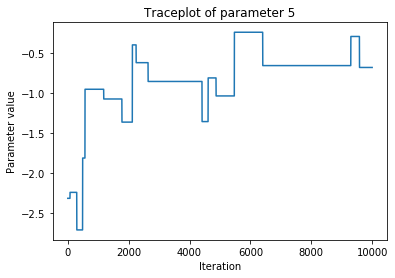

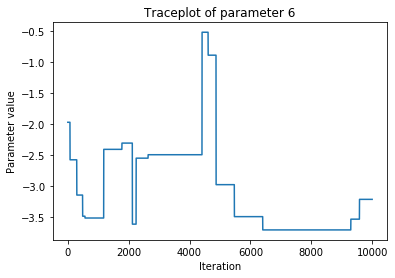

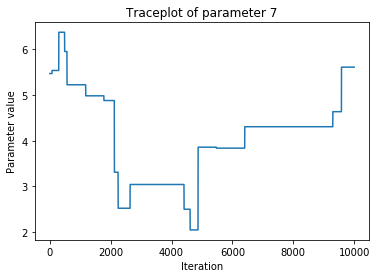

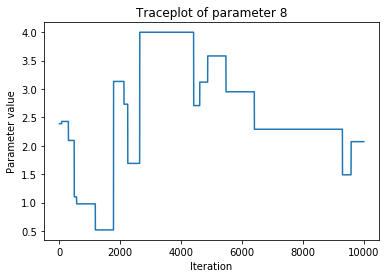

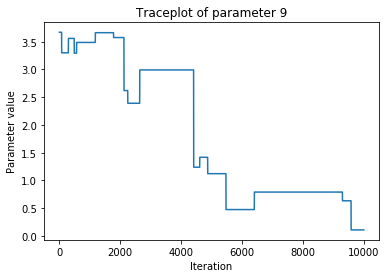

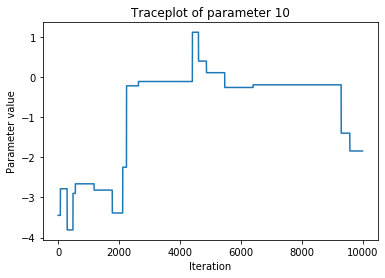

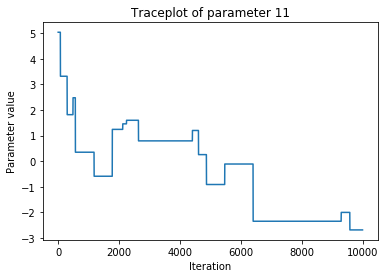

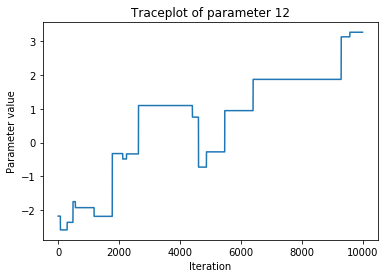

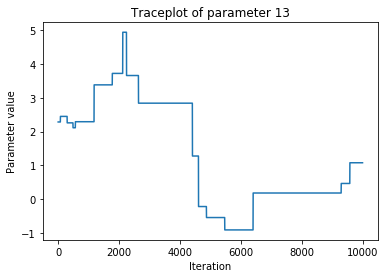

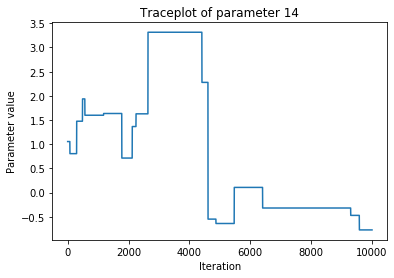

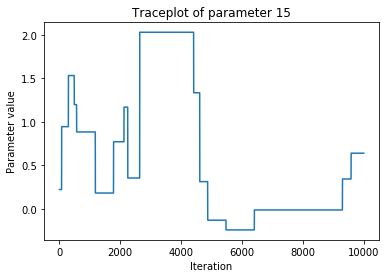

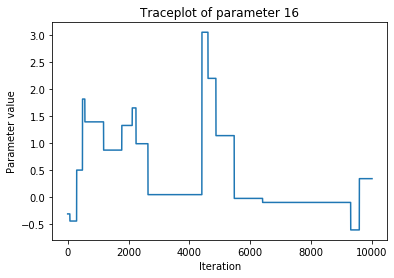

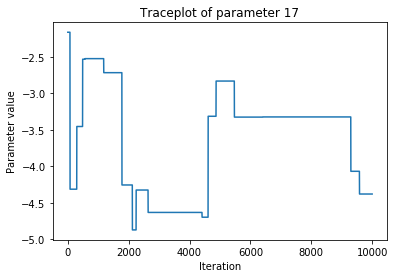

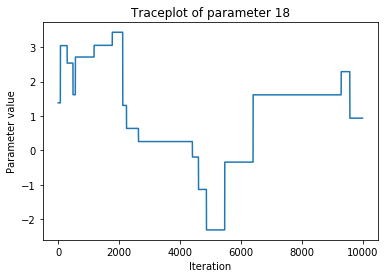

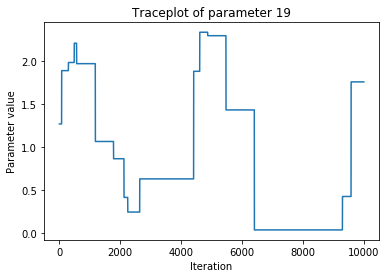

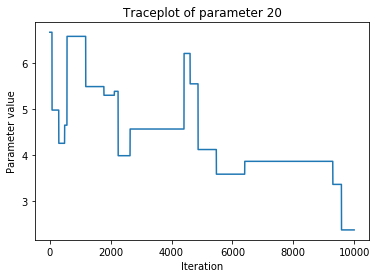

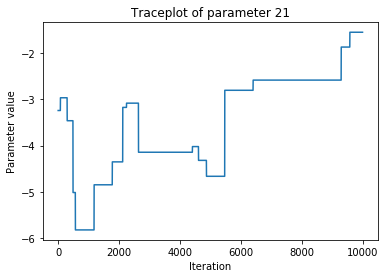

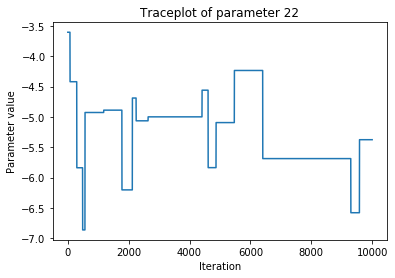

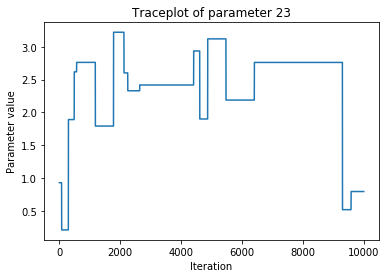

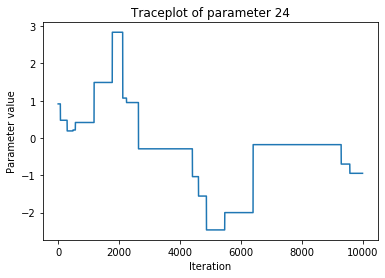

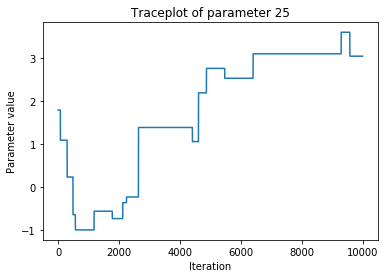

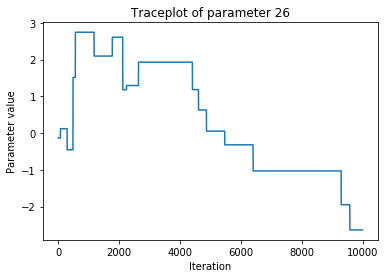

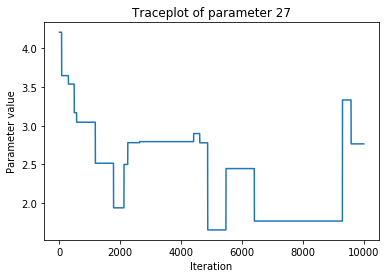

In [9]:
## Plot traces of simulated Markov chain

for i in range(model.num_params()):
    chain = sampler.chain.get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter {}'.format(i+1))

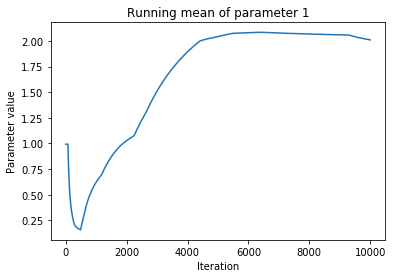

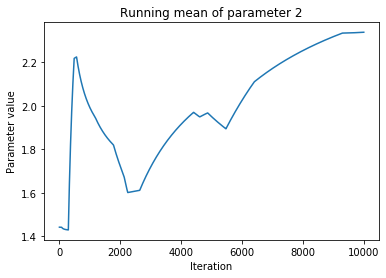

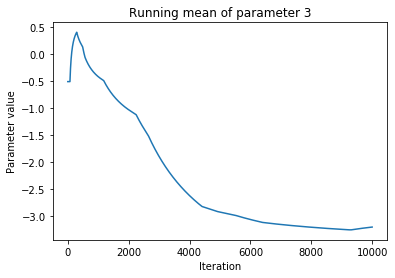

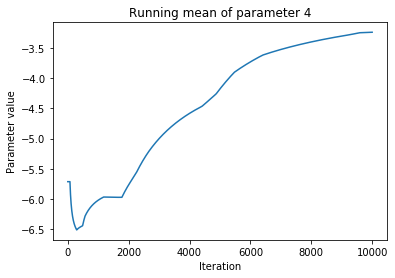

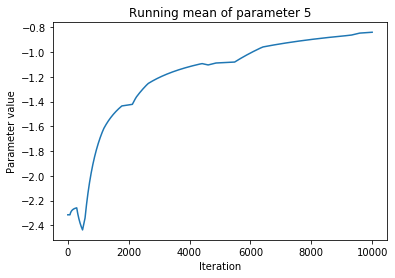

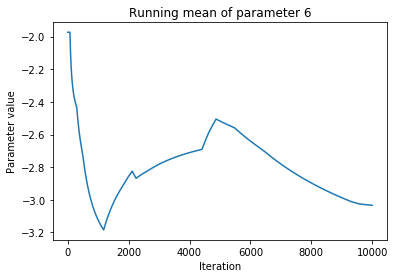

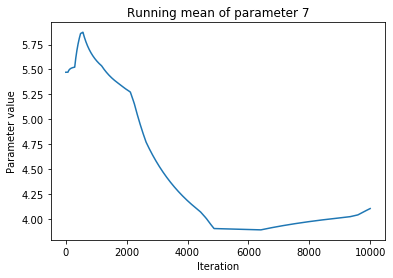

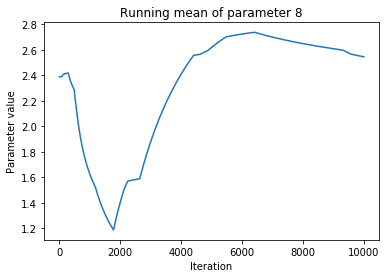

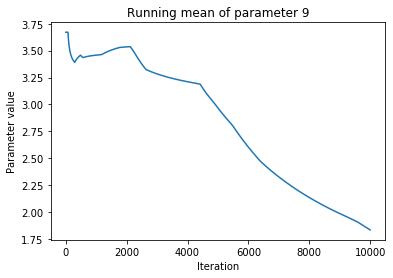

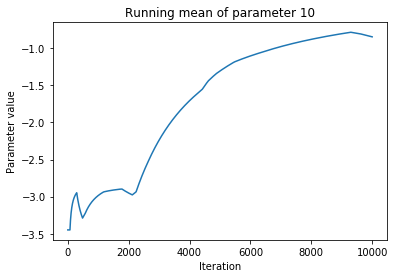

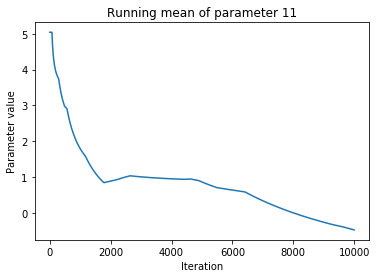

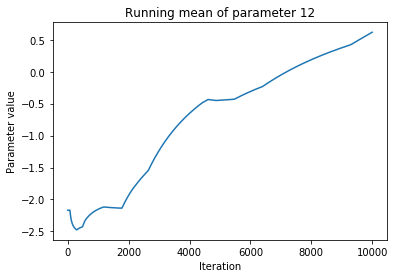

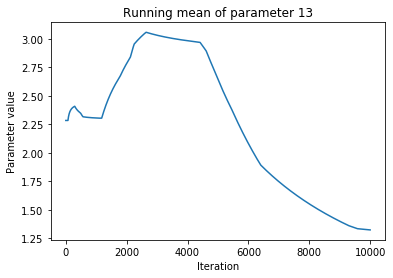

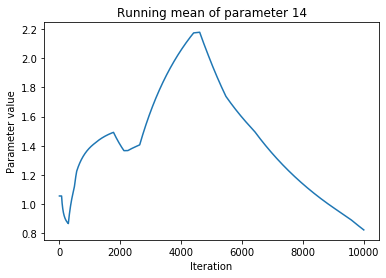

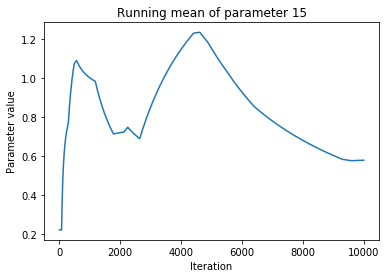

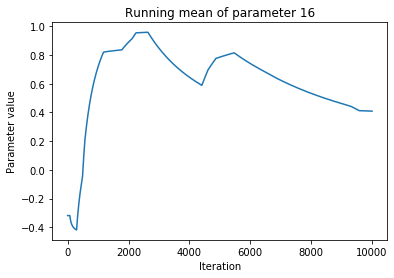

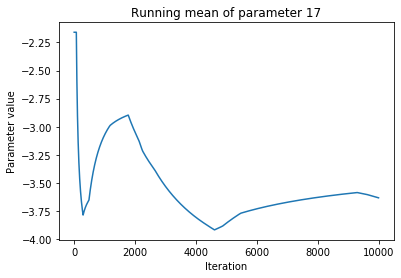

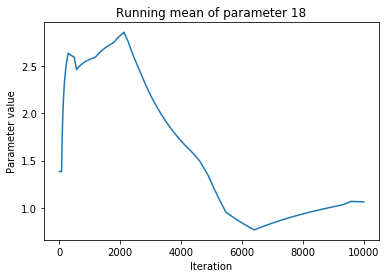

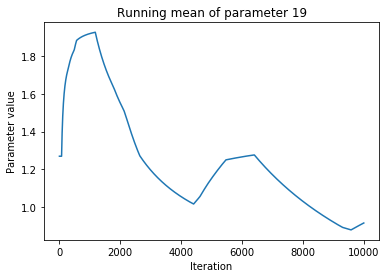

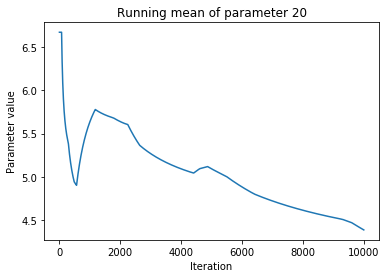

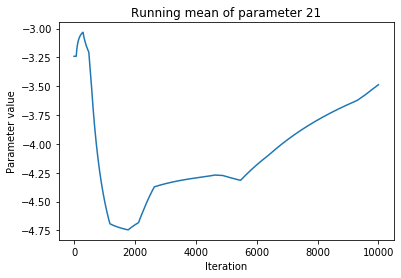

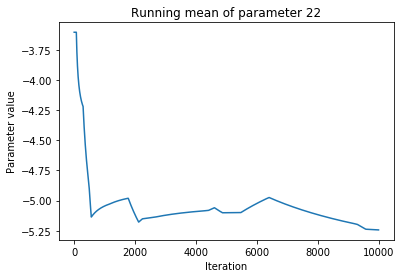

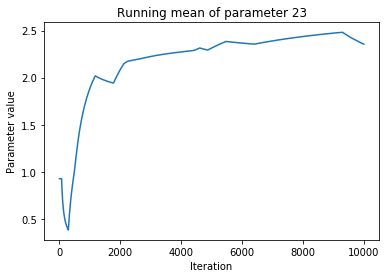

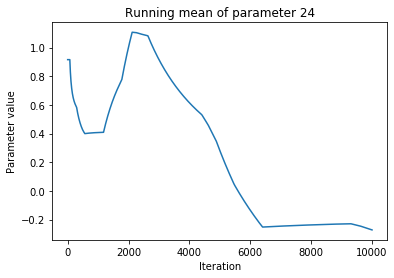

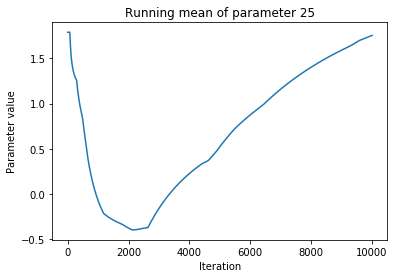

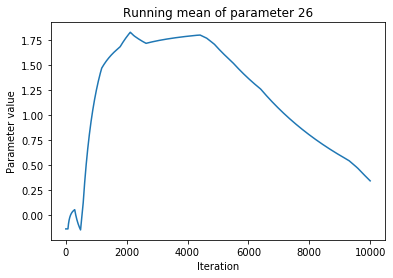

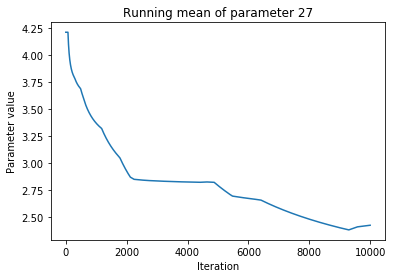

In [10]:
## Plot running means of simulated Markov chain

for i in range(model.num_params()):
    chain = sampler.chain.get_theta(i)
    chain_mean = torch.empty(len(chain))
    chain_mean[0] = chain[0]
    for j in range(1, len(chain)):
        chain_mean[j] = (chain[j]+j*chain_mean[j-1])/(j+1)
        
    plt.figure()
    sns.lineplot(range(len(chain)), chain_mean)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Running mean of parameter {}'.format(i+1))

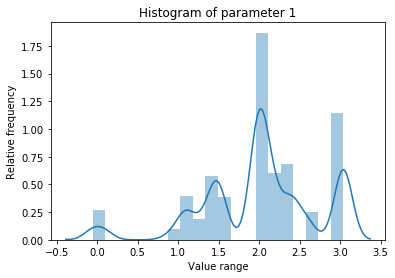

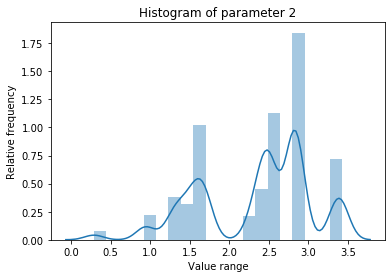

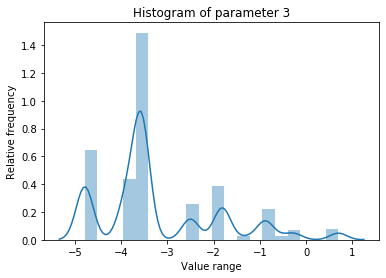

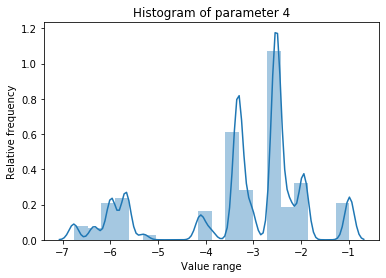

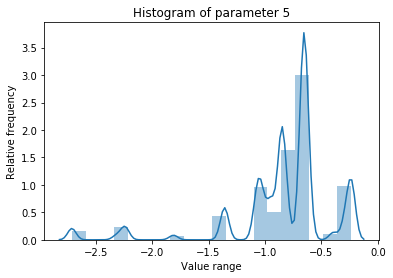

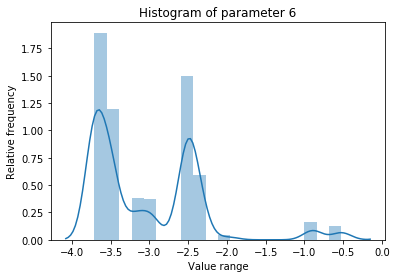

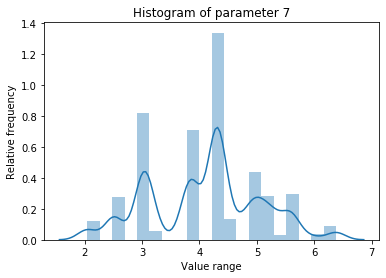

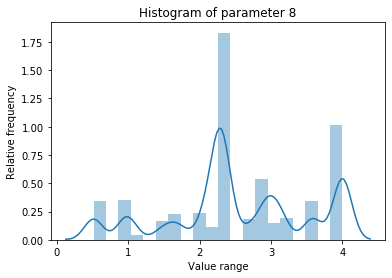

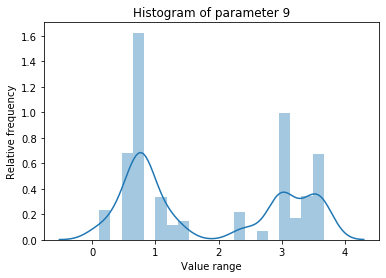

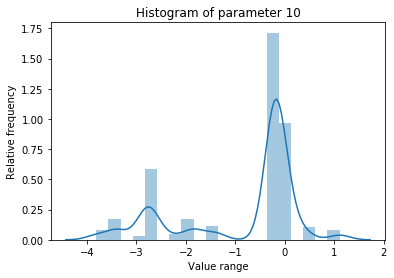

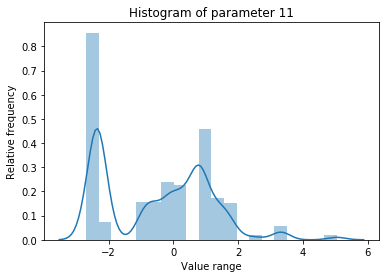

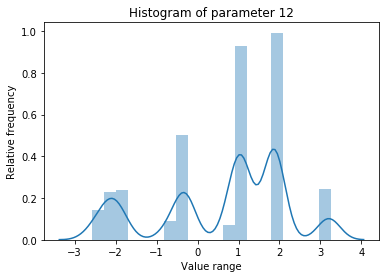

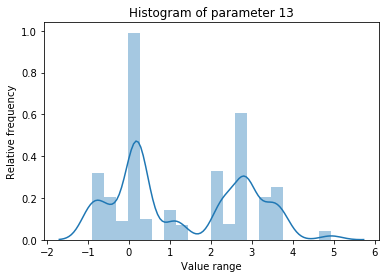

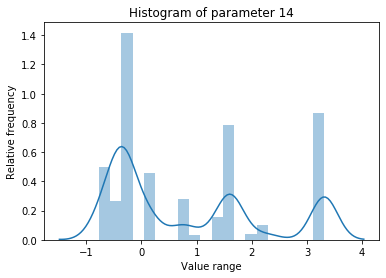

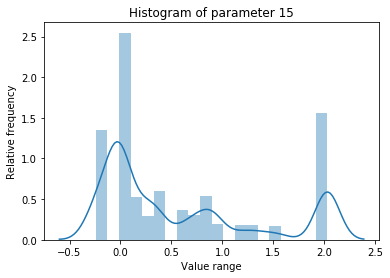

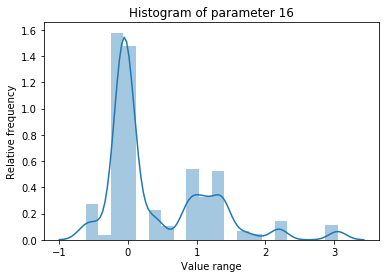

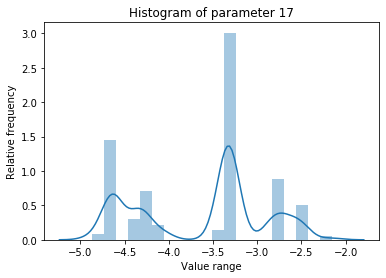

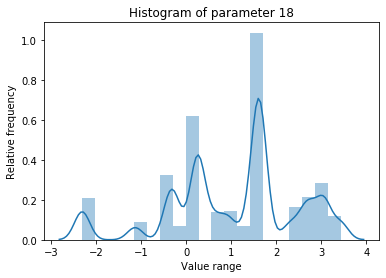

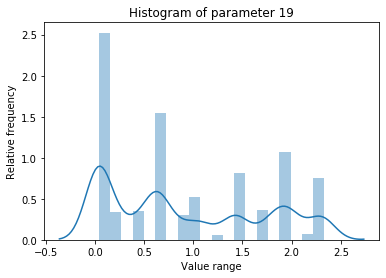

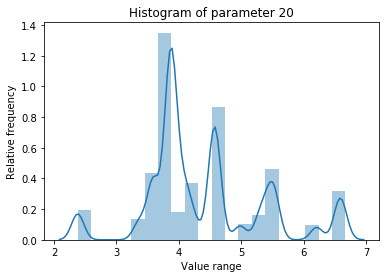

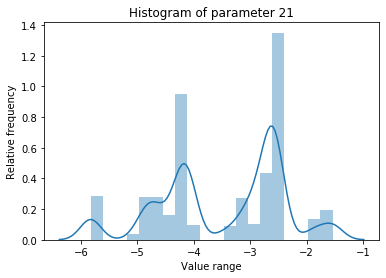

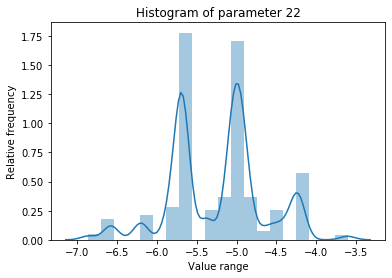

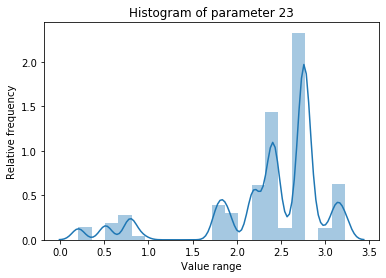

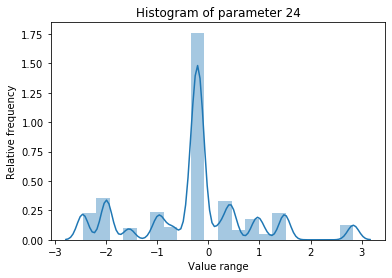

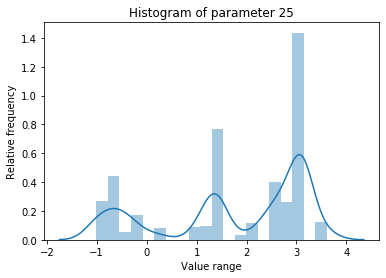

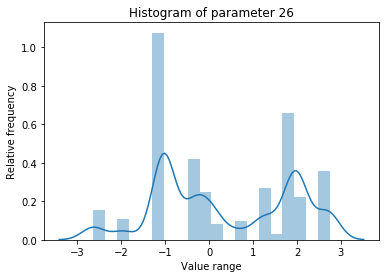

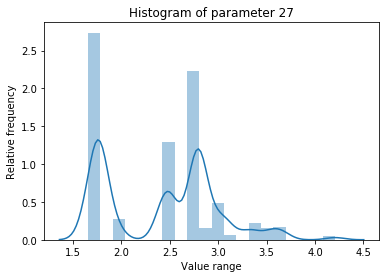

In [11]:
## Plot histograms of simulated Markov chain

for i in range(model.num_params()):
    plt.figure()
    sns.distplot(sampler.chain.get_theta(i), bins=20, norm_hist=True)
    plt.xlabel('Value range')
    plt.ylabel('Relative frequency')
    plt.title(r'Histogram of parameter {}'.format(i+1))